# BiLSTM Model

This script allows for the training of a Bidirectional Long-Short-Term Memory (BiLSTM) recurrent neural network. The script:

*   Takes .txt files as input (formatted similarly to Ninapro .txt files)
*   Preprocesses the data, generates the model input and pickles the input data
*   Trains and evaluates the model







Model ouline and functions from existing GitHub Repo:
https://github.com/sherry-s-yuan/gesture_classification/tree/master

# Initilaize Modules

In [1]:
from keras.layers import Input, Flatten, Dense, Dropout, LSTM, Bidirectional, concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, f1_score, recall_score
import numpy as np
from google.colab import drive
# Mount google Drive
drive.mount('/content/drive')
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import os
import numpy as np
import pickle
import keras

Mounted at /content/drive


# BiLSTM Model

In [2]:
class BILSTM:
    def train(self, X_emg_train, X_acc_train, zc_features_train, ssc_features_train, features_1d_train_emg, features_1d_train_acc, Y_train,
              X_emg_val, X_acc_val, zc_features_val, ssc_features_val, features_1d_val_emg, features_1d_val_acc, Y_val, num_activation=100):

        """"construct model architecture"""
        # input layer setup
        x_emg_branch_input = Input(shape=(X_emg_train.shape[1], X_emg_train.shape[2]))
        x_acc_branch_input = Input(shape=(X_acc_train.shape[1], X_acc_train.shape[2]))
        zc_branch_input = Input(shape=(zc_features_train.shape[1], zc_features_train.shape[2]))
        ssc_branch_input = Input(shape=(ssc_features_train.shape[1], ssc_features_train.shape[2]))
        oned_branch_input_emg = Input(shape=(features_1d_train_emg.shape[1], features_1d_train_emg.shape[2]))
        oned_branch_input_acc = Input(shape=(features_1d_train_acc.shape[1], features_1d_train_acc.shape[2]))

        # branch setup
        x_emg_branch = Bidirectional(LSTM(num_activation))(x_emg_branch_input)
        x_emg_branch = Dropout(0.5)(x_emg_branch)
        x_emg_branch = Dense(num_activation, activation='relu')(x_emg_branch)
        x_emg_branch = Model(inputs=x_emg_branch_input, outputs=x_emg_branch)

        x_acc_branch = Bidirectional(LSTM(num_activation))(x_acc_branch_input)
        x_acc_branch = Dropout(0.5)(x_acc_branch)
        x_acc_branch = Dense(num_activation, activation='relu')(x_acc_branch)
        x_acc_branch = Model(inputs=x_acc_branch_input, outputs=x_acc_branch)

        zc_branch = Bidirectional(LSTM(num_activation))(zc_branch_input)
        zc_branch = Dropout(0.3)(zc_branch)
        zc_branch = Dense(num_activation, activation='relu')(zc_branch)
        zc_branch = Model(inputs=zc_branch_input, outputs=zc_branch)

        ssc_branch = Bidirectional(LSTM(num_activation))(ssc_branch_input)
        ssc_branch = Dropout(0.3)(ssc_branch)
        ssc_branch = Dense(num_activation, activation='relu')(ssc_branch)
        ssc_branch = Model(inputs=ssc_branch_input, outputs=ssc_branch)

        oned_branch_emg = Flatten()(oned_branch_input_emg)
        oned_branch_emg = Dense(num_activation, activation='relu')(oned_branch_emg)
        oned_branch_emg = Model(inputs=oned_branch_input_emg, outputs=oned_branch_emg)

        oned_branch_acc = Flatten()(oned_branch_input_acc)
        oned_branch_acc = Dense(num_activation, activation='relu')(oned_branch_acc)
        oned_branch_acc = Model(inputs=oned_branch_input_acc, outputs=oned_branch_acc)


        # root setup
        combined = concatenate([x_emg_branch.output, x_acc_branch.output, zc_branch.output, ssc_branch.output, oned_branch_emg.output, oned_branch_acc.output])
        combined = Dense(num_activation, activation='relu')(combined)
        combined = Dropout(0.3)(combined)
        combined = Dense(7, activation='relu')(combined)
        combined = Dense(2, activation='softmax')(combined)

        # compile model
        self.model = Model(inputs=[x_emg_branch_input, x_acc_branch_input, zc_branch_input, ssc_branch_input, oned_branch_input_emg, oned_branch_input_acc], outputs=combined)

        # Create optimizer with custom learning rate schedule
        initial_learning_rate = 0.01
        decay_factor = 0.1
        decay_steps = 1000
        lr_schedule = CustomLearningRateSchedule(initial_learning_rate, decay_factor, decay_steps)
        opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        # Calculate class weights
        # Flatten Y_train and Y_val
        Y_train_flat = np.argmax(Y_train, axis=1)
        Y_val_flat = np.argmax(Y_val, axis=1)
        class_labels = np.unique(Y_train)
        class_weights = compute_class_weight(
                                                  class_weight = 'balanced',
                                                  classes = class_labels,
                                                  y=Y_train_flat)

        # Convert class weights to a dictionary
        class_weight_dict = dict(zip(class_labels, class_weights))

        optimize = keras.optimizers.Adam(learning_rate=0.001)
        # Compile model with class weights
        self.model.compile(loss="categorical_crossentropy", optimizer=optimize, metrics=['accuracy'])

        # fit model
        history = self.model.fit([X_emg_train, X_acc_train, zc_features_train, ssc_features_train, features_1d_train_emg, features_1d_train_acc], Y_train, epochs=60, batch_size=256,
                        validation_data=([X_emg_val, X_acc_val, zc_features_val, ssc_features_val, features_1d_val_emg, features_1d_val_acc], Y_val), class_weight=class_weight_dict)

        print(self.model.summary())

        # Plot training history (optional)
        self.plot_training_history(history)

    def plot_training_history(self, history):
        import matplotlib.pyplot as plt

        # Plot training & validation accuracy values
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

        # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

    # Model Evaluation
    def evaluate(self, X_emg_test, X_acc_test, zc_features_test, ssc_features_test, features_1d_test_emg, features_1d_test_acc, Y_test):
        loss, accuracy = self.model.evaluate([X_emg_test, X_acc_test, zc_features_test, ssc_features_test, features_1d_test_emg, features_1d_test_acc], Y_test)
        predictions = self.model.predict([X_emg_test, X_acc_test, zc_features_test, ssc_features_test, features_1d_test_emg, features_1d_test_acc])
        # Calculate Metrics
        precision = precision_score(np.argmax(Y_test, axis=1), np.argmax(predictions, axis=1))
        recall = recall_score(np.argmax(Y_test, axis=1), np.argmax(predictions, axis=1))
        f1 = f1_score(np.argmax(Y_test, axis=1), np.argmax(predictions, axis=1))
        print("Test Loss:", loss)
        print("Test Accuracy:", accuracy)
        print("Precision:", precision)
        print("F1 Score:", f1)
        print("Recall:", recall)
        return accuracy, loss, f1, precision, recall

    def predict(self, X_emg, zc_features, ssc_features, features_1d_emg, features_1d_acc):
        # precondition: passed in data must be normalized.
        return self.get_class(self.model.predict([X_emg, X_acc, zc_features, ssc_features, features_1d_emg, features_1d_acc]))

    def get_class(self, predictions):
      """get class label from one hot encoding"""
      if isinstance(predictions, int):
        # IF predictions is a single integer, return it directly
        return predictions
      elif isinstance(predictions, np.ndarray):
        result = np.argmax(predictions, axis = 1)
        return result
      else:
          #prediction = prediction.tolist()
          raise ValueError("Unsupported type for prediction: {}".format(type(predictions)))
        #return np.array(result)

    def load_model(file_path):
        smodel = load_model('file_path')

    def save_model(self):
        self.model.save("model.h5")

Learning rate decay function (did not end up using)


In [3]:
class CustomLearningRateSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, decay_factor, decay_steps):
        super(CustomLearningRateSchedule, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.decay_factor = decay_factor
        self.decay_steps = decay_steps

    def __call__(self, step):
        return self.initial_learning_rate * self.decay_factor ** (step / self.decay_steps)


# Preprocessing Data b4 Training

In [4]:
class Signal:
    def __init__(self, path):
        self.data = pd.read_csv(path, delimiter='\t', encoding='UTF-8')
        # filter out class 0 and 7
        self.data = self.data.loc[self.data['class'] != 7]
        #self.data = self.data.loc[self.data['class'] != 0]
        # load in data
        self.label = self.data['class'].to_numpy()
        self.time = self.data['time']
        self.data_emg = self.data.iloc[:, 1:9]
        self.data_acc = self.data.iloc[:, 9:12]
        self.x_emg = []
        self.x_acc = []
        self.filename = path.split('/')[-1].split('.txt')[0]

    # Window Raw Data
    def generate(self, step=20, window=375):
        """break time series data into periods of windows of 0.75 seconds for detection"""
        self.x_emg = []
        self.x_acc = []
        self.y = []
        print('Generating Data...')
        for i in range(0, self.data_emg.shape[0], step):
            if self.data_emg.shape[0] - i < 375:
                break
            # Generate one hot encoding of labels
            label = [0, 0]  # Two classes
            majority_class = self._majority_class(self.label[i:i+window])
            label[majority_class] = 1
            self.y.append(label)
            self.x_emg.append(self.data_emg.iloc[i:i+window, :])
            self.x_acc.append(self.data_acc.iloc[i:i+window, :])
        self.x_emg = np.array(self.x_emg)
        self.x_acc = np.array(self.x_acc)
        self.y = np.array(self.y)

    # Generate features
    def feature_generation(self):
        """prepare all ssc, zc, average, rms etc features"""
        self.ssc_feature = []
        self.zc_feature = []
        self.feature_1d_emg = []
        self.feature_1d_acc = []
        for timeframe in self.x_emg:
            self.ssc_feature.append(self.SSC_EMG(timeframe))
            self.zc_feature.append(self.ZC_EMG(timeframe))
            self.feature_1d_emg.append(self.feature_extraction_1D_emg(timeframe))
        for timeframe in self.x_acc:
            self.feature_1d_acc.append(self.feature_extraction_1D_acc(timeframe))

        self.ssc_feature = np.array(self.ssc_feature)
        self.zc_feature = np.array(self.zc_feature)
        self.feature_1d_emg = np.array(self.feature_1d_emg)
        self.feature_1d_acc = np.array(self.feature_1d_acc)

    # Multi-Dimension Features
    def ZC_EMG(self, x):
        """compute zero crossing, return (window, channel)"""
        a2 = np.sign(x[:,:8])
        change2 = ((np.roll(a2, 1, axis=0) - a2) != 0).astype(int)
        return change2

    def ZC_ACCEL(self, x):
        """compute zero crossing, return (window, channel)"""
        a2 = np.sign(x[:,-3:])
        change2 = ((np.roll(a2, 1, axis=0) - a2) != 0).astype(int)
        return change2

    def SSC_EMG(self, x):
        """detect slope change, return (window-1, channel)"""
        a = np.sign(np.diff(x[:,:8], axis=0))
        change = ((np.roll(a, 1, axis=0) - a) != 0).astype(int)
        return change

    def SSC_ACCEL(self, x):
        """detect slope change, return (window-1, channel)"""
        a = np.sign(np.diff(x[:,-3:], axis=0))
        change = ((np.roll(a, 1, axis=0) - a) != 0).astype(int)
        return change

# Single-Dimension Features

    # Mean Absolute Value
    def MAV_EMG(self, x):
        """compute mean absolute value, return (1, channel)"""
        return np.mean(np.abs(x), axis=0) #pd.DataFrame(x.abs().mean(axis=0)).T

    def MAV_acceleration(self, x):
        """Compute mean absolute value for acceleration data, return (1, channel)"""
        return np.mean(np.abs(x), axis=0)

    # Waveform Length (WL)
    def WL_EMG(self, x):
        """waveform length feature extraction, return (1, channel)"""
        # columns = x.columns
        a = np.sum(np.diff(x, axis=0), axis=0)
        # change = pd.DataFrame(a).T
        # change.columns = columns
        return a #change

    def WL_acceleration(self, x):
        """Waveform length feature extraction for acceleration data, return (1, channel)"""
        a = np.sum(np.diff(x, axis=0), axis=0)
        return a

    # Standard Deviation (STD)
    def STD_EMG(self, x):
        """standard deviation of the channels, return (1, channel)"""
        return x.std(axis=0) # pd.DataFrame(x.std(axis=0)).T

    def STD_acceleration(self, x):
        """Standard deviation of the channels for acceleration data, return (1, channel)"""
        return x.std(axis=0)

    # Root Mean Square (RMS)
    def RMS_EMG(self, x):
        """Root mean squared, return (1, channel)"""
        return ((x ** 2).sum(axis=0) / x.shape[0]) ** (1 / 2) # pd.DataFrame(((x ** 2).sum(axis=0) / x.shape[0]) ** (1 / 2)).T

    def RMS_acceleration(self, x):
        """Root mean squared for acceleration data, return (1, channel)"""
        return ((x ** 2).sum(axis=0) / x.shape[0]) ** (1 / 2)


    def _majority_class(self, labels, threshold=0.25):
        """Return 1 if positive count is 25% or more of the total count, otherwise return 0."""
        # Check if positive proportion meets or exceeds the threshold
        positive_proportion = np.mean(labels)
        if positive_proportion >= threshold:
            first_value = labels[0]
            final_value = labels[-1]
            # Check if it's entering, in the middle, or leaving a window
            if first_value == 0 and final_value == 1:
                return 1
            elif first_value == 1 and final_value == 1:
                return 1
            elif first_value == 1 and final_value == 0:
                # Check if it's leaving and if the proportion is less than 0.5
                if positive_proportion <= 0.5:
                    return 0
                else:
                    return 1
        else:
            return 0


    def feature_extraction_1D_emg(self, x):
        """join all 1D feature together"""
        #EMG Feature Extraction
        rms = [self.RMS_EMG(x)]
        wl_emg = self.WL_EMG(x)
        std_emg = self.STD_EMG(x)
        mav_emg = self.MAV_EMG(x)
        #Append all features together now
        rms.append(wl_emg)
        rms.append(std_emg)
        rms.append(mav_emg)
        return np.array(rms)

    def feature_extraction_1D_acc(self, x):
        """join all 1D feature together"""
        #WACCEL Feature Extraction
        rms = [self.RMS_acceleration(x)]
        wl_accel = self.WL_acceleration(x)
        std_accel = self.STD_acceleration(x)
        mav_accel = self.MAV_acceleration(x)

        #Append all features together now
        rms.append(wl_accel)
        rms.append(std_accel)
        rms.append(mav_accel)
        return np.array(rms)

    def to_numpy(self):
        self.data = self.data.to_numpy()

    def save_data(self):
        directory = "./data"
        if not os.path.exists(directory):
            os.makedirs(directory)
        np.save("./data/" + self.filename + '_y', self.y)
        np.save("./data/" + self.filename + '_x_emg', self.x_emg)
        np.save("./data/" + self.filename + '_x_acc', self.x_acc)
        np.save("./data/" + self.filename + '_zc', self.zc_feature)
        np.save("./data/" + self.filename + '_ssc', self.ssc_feature)
        np.save("./data/" + self.filename + '_1d_emg', self.feature_1d_emg)
        np.save("./data/" + self.filename + '_1d_acc', self.feature_1d_acc)

    def load_data(self):
        y = np.load("./data/" + self.filename + '_y' + ".npy")
        x_emg = np.load("./data/" + self.filename + '_x_emg' + ".npy")
        x_acc = np.load("./data/" + self.filename + '_x_acc' + ".npy")
        zc_feature = np.load("./data/" + self.filename + '_zc' + ".npy")
        ssc_feature = np.load("./data/" + self.filename + '_ssc' + ".npy")
        feature_1d_emg = np.load("./data/" + self.filename + '_1d_emg' + ".npy")
        feature_1d_acc= np.load("./data/" + self.filename + '_1d_acc' + ".npy")
        return x_emg, x_acc, zc_feature, ssc_feature, feature_1d_emg, feature_1d_acc, y

class Data:
    def __init__(self, X_emg, X_acc, zc_features, ssc_features, features_1d_emg, features_1d_acc, Y):
        print("Train val Split:")
        # get training dataset index
        self.original_indices = np.arange(X_emg.shape[0])
        # Manually select train/validation split below.
        # If doing k-fold, X_emg.shape[0] * 0.99
        # If else, X_emg.shape[0] * 0.80
        train_ind = np.random.choice(self.original_indices, int(X_emg.shape[0] * 0.99), replace=False)
        val_ind = np.setdiff1d(self.original_indices, train_ind)

        # Shuffle indices for training and validation sets
        self.train_indices = train_ind
        self.val_indices = val_ind

        # Training data
        self.X_emg_train = X_emg[train_ind]
        self.X_acc_train = X_acc[train_ind]
        self.zc_features_train = zc_features[train_ind]
        self.ssc_features_train = ssc_features[train_ind]
        self.features_1d_train_emg = features_1d_emg[train_ind]
        self.features_1d_train_acc = features_1d_acc[train_ind]
        self.Y_train = Y[train_ind]

        # Validation data
        self.X_emg_val = X_emg[val_ind]
        self.X_acc_val = X_acc[val_ind]
        self.zc_features_val = zc_features[val_ind]
        self.ssc_features_val = ssc_features[val_ind]
        self.features_1d_val_emg = features_1d_emg[val_ind]
        self.features_1d_val_acc = features_1d_acc[val_ind]
        self.Y_val = Y[val_ind]
        # normalization scaler storage
        self.x_emg_scaler = {}
        self.x_acc_scaler = {}
        self.zc_scaler = {}
        self.ssc_scaler = {}
        self.oned_scaler_emg = {}
        self.oned_scaler_acc = {}
        self.normalize_train_val() # normalize data using StandardScaler

    def normalize_train_val(self):
        # using scaler fitted on training data on val data
        if len(self.x_emg_scaler) == 0:
            # fit transform training set
            for i in range(self.X_emg_train.shape[1]):
                self.x_emg_scaler[i] = StandardScaler()
                self.X_emg_train[:, i, :] = self.x_emg_scaler[i].fit_transform(self.X_emg_train[:, i, :])
            for i in range(self.X_acc_train.shape[1]):
                self.x_acc_scaler[i] = StandardScaler()
                self.X_acc_train[:, i, :] = self.x_acc_scaler[i].fit_transform(self.X_acc_train[:, i, :])
            for i in range(self.zc_features_train.shape[1]):
                self.zc_scaler[i] = StandardScaler()
                self.zc_features_train[:, i, :] = self.zc_scaler[i].fit_transform(self.zc_features_train[:, i, :])
            for i in range(self.ssc_features_train.shape[1]):
                self.ssc_scaler[i] = StandardScaler()
                self.ssc_features_train[:, i, :] = self.ssc_scaler[i].fit_transform(self.ssc_features_train[:, i, :])
            for i in range(self.features_1d_train_emg.shape[1]):
                self.oned_scaler_emg[i] = StandardScaler()
                self.features_1d_train_emg[:, i, :] = self.oned_scaler_emg[i].fit_transform(self.features_1d_train_emg[:, i, :])
            for i in range(self.features_1d_train_acc.shape[1]):
                self.oned_scaler_acc[i] = StandardScaler()
                self.features_1d_train_acc[:, i, :] = self.oned_scaler_acc[i].fit_transform(self.features_1d_train_acc[:, i, :])
        # fit transform val
        for i in range(self.X_emg_val.shape[1]):
            self.X_emg_val[:, i, :] = self.x_emg_scaler[i].transform(self.X_emg_val[:, i, :])
        for i in range(self.X_acc_val.shape[1]):
            self.X_acc_val[:, i, :] = self.x_acc_scaler[i].transform(self.X_acc_val[:, i, :])
        for i in range(self.zc_features_val.shape[1]):
            self.zc_features_val[:, i, :] = self.zc_scaler[i].transform(self.zc_features_val[:, i, :])
        for i in range(self.ssc_features_val.shape[1]):
            self.ssc_features_val[:, i, :] = self.ssc_scaler[i].transform(self.ssc_features_val[:, i, :])
        for i in range(self.features_1d_val_emg.shape[1]):
            self.features_1d_val_emg[:, i, :] = self.oned_scaler_emg[i].transform(self.features_1d_val_emg[:, i, :])
        for i in range(self.features_1d_val_acc.shape[1]):
            self.features_1d_val_acc[:, i, :] = self.oned_scaler_acc[i].transform(self.features_1d_val_acc[:, i, :])

    def normalize(self, X_emg, X_acc, zc_features, ssc_features, features_1d_emg, features_1d_acc):
        """this function manipute the variables directly: aliasing"""
        for i in range(self.X_emg_val.shape[1]):
            X_emg[:, i, :] = self.x_emg_scaler[i].transform(X_emg[:, i, :])
        for i in range(self.X_acc_val.shape[1]):
            X_acc[:, i, :] = self.x_acc_scaler[i].transform(X_acc[:, i, :])
        for i in range(self.zc_features_val.shape[1]):
            zc_features[:, i, :] = self.zc_scaler[i].transform(zc_features[:, i, :])
        for i in range(self.ssc_features_val.shape[1]):
            ssc_features[:, i, :] = self.ssc_scaler[i].transform(ssc_features[:, i, :])
        for i in range(self.features_1d_val_emg.shape[1]):
            features_1d_emg[:, i, :] = self.oned_scaler_emg[i].transform(features_1d_emg[:, i, :])
        for i in range(self.features_1d_val_acc.shape[1]):
            features_1d_acc[:, i, :] = self.oned_scaler_acc[i].transform(features_1d_acc[:, i, :])
        return X_emg, X_acc, zc_features, ssc_features, features_1d_emg, features_1d_acc


# Generate Testing Data
This section can be used for generating data for both k-fold and individual model training

In [5]:
import os
import numpy as np
import pickle

# Prepare paths to data access
print("Prepare Training/Validation Paths:")
paths = []
repository = "/content/drive/MyDrive/Thesis/Data/Segmented_Data/LSTM_GH_Data/Mindrove_Data/Thesis/DishWashing"

# Check if the directory exists
if os.path.exists(repository):
    # Get all .txt files in the directory
    files = [os.path.join(repository, f) for f in os.listdir(repository) if f.endswith('.txt')]
    paths.extend(files)
else:
    print("Directory does not exist:", repository)

# Preprocessing Signal File
print("Processing Training/Validation Signal Files:")
signals = []
count = 0
for path in paths:
    # if count >= 14:
    #     break
    print(path)
    signal = Signal(path)
    signal.to_numpy()
    signal.generate()
    signal.feature_generation()
    signal.save_data()
    signals.append(signal)
    count += 1

# Concatenate Train val Data
print("Concatenate Training, Validation Data:")
X_emg, X_acc, zc_features, ssc_features, features_1d_emg, features_1d_acc, Y = signals[0].load_data()
for signal in signals[1:]:
    x_emg,x_acc, zc_feature, ssc_feature, feature_1d_emg, feature_1d_acc, y = signal.load_data()
    X_emg = np.append(X_emg, x_emg, axis=0)
    X_acc = np.append(X_acc, x_acc, axis=0)
    zc_features = np.append(zc_features, zc_feature, axis=0)
    ssc_features = np.append(ssc_features, ssc_feature, axis=0)
    features_1d_emg = np.append(features_1d_emg, feature_1d_emg, axis=0)
    features_1d_acc = np.append(features_1d_acc, feature_1d_acc, axis=0)
    Y = np.append(Y, y, axis=0)

# Check for NaN values in concatenated arrays
nan_indices_X_emg = np.argwhere(np.isnan(X_emg))
nan_indices_X_acc = np.argwhere(np.isnan(X_acc))
nan_indices_zc = np.argwhere(np.isnan(zc_features))
nan_indices_ssc = np.argwhere(np.isnan(ssc_features))
nan_indices_features_1d_emg = np.argwhere(np.isnan(features_1d_emg))
nan_indices_features_1d_acc = np.argwhere(np.isnan(features_1d_acc))
nan_indices_Y = np.argwhere(np.isnan(Y))
if len(nan_indices_X_emg) > 0:
    print("NaN values found in X at indices:", nan_indices_X_emg)
if len(nan_indices_X_acc) > 0:
    print("NaN values found in X at indices:", nan_indices_X_acc)
if len(nan_indices_zc) > 0:
    print("NaN values found in zc_features at indices:", nan_indices_zc)
if len(nan_indices_ssc) > 0:
    print("NaN values found in ssc_features at indices:", nan_indices_ssc)
if len(nan_indices_features_1d_emg) > 0:
    print("NaN values found in features_1d at indices:", nan_indices_features_1d_emg)
if len(nan_indices_features_1d_acc) > 0:
    print("NaN values found in features_1d_2 at indices:", nan_indices_features_1d_acc)
if len(nan_indices_Y) > 0:
    print("NaN values found in Y at indices:", nan_indices_Y)

# Prepare Data
testing_flag = 0
data = Data(X_emg, X_acc, zc_features, ssc_features, features_1d_emg, features_1d_acc, Y)
print("Pickling Data")
# dump data
with open('k_fold_dishwashing.pickle', 'wb') as f:
    pickle.dump(data,f,protocol=pickle.HIGHEST_PROTOCOL)


Prepare Training/Validation Paths:
Processing Training/Validation Signal Files:
/content/drive/MyDrive/Thesis/Data/Segmented_Data/LSTM_GH_Data/Mindrove_Data/Thesis/DishWashing/Dish Washing 1.txt
Generating Data...
/content/drive/MyDrive/Thesis/Data/Segmented_Data/LSTM_GH_Data/Mindrove_Data/Thesis/DishWashing/Dish Washing 2.txt
Generating Data...
/content/drive/MyDrive/Thesis/Data/Segmented_Data/LSTM_GH_Data/Mindrove_Data/Thesis/DishWashing/Dish Washing 3.txt
Generating Data...
/content/drive/MyDrive/Thesis/Data/Segmented_Data/LSTM_GH_Data/Mindrove_Data/Thesis/DishWashing/Dish Washing 4.txt
Generating Data...
/content/drive/MyDrive/Thesis/Data/Segmented_Data/LSTM_GH_Data/Mindrove_Data/Thesis/DishWashing/Dish Washing 5.txt
Generating Data...
/content/drive/MyDrive/Thesis/Data/Segmented_Data/LSTM_GH_Data/Mindrove_Data/Thesis/DishWashing/6_11_21_48.txt
Generating Data...
/content/drive/MyDrive/Thesis/Data/Segmented_Data/LSTM_GH_Data/Mindrove_Data/Thesis/DishWashing/7_11_28_40.txt
Generatin

# K-fold Cross validation


Epoch 1/60
188/188 [==============================] - 340s 2s/step - loss: 0.4935 - accuracy: 0.7426 - val_loss: 0.4070 - val_accuracy: 0.8056
Epoch 2/60
188/188 [==============================] - 318s 2s/step - loss: 0.3949 - accuracy: 0.8029 - val_loss: 0.3394 - val_accuracy: 0.8442
Epoch 3/60
188/188 [==============================] - 320s 2s/step - loss: 0.3662 - accuracy: 0.8206 - val_loss: 0.3841 - val_accuracy: 0.8204
Epoch 4/60
188/188 [==============================] - 326s 2s/step - loss: 0.3518 - accuracy: 0.8281 - val_loss: 0.3282 - val_accuracy: 0.8456
Epoch 5/60
188/188 [==============================] - 322s 2s/step - loss: 0.3375 - accuracy: 0.8341 - val_loss: 0.3652 - val_accuracy: 0.8276
Epoch 6/60
188/188 [==============================] - 304s 2s/step - loss: 0.3173 - accuracy: 0.8468 - val_loss: 0.3157 - val_accuracy: 0.8551
Epoch 7/60
188/188 [==============================] - 307s 2s/step - loss: 0.3037 - accuracy: 0.8538 - val_loss: 0.3456 - val_accuracy: 0.8407

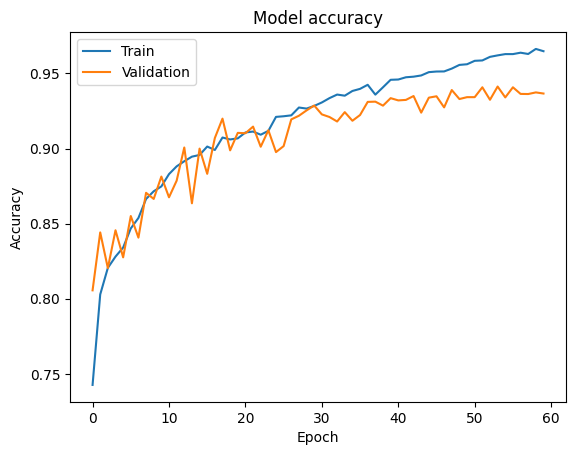

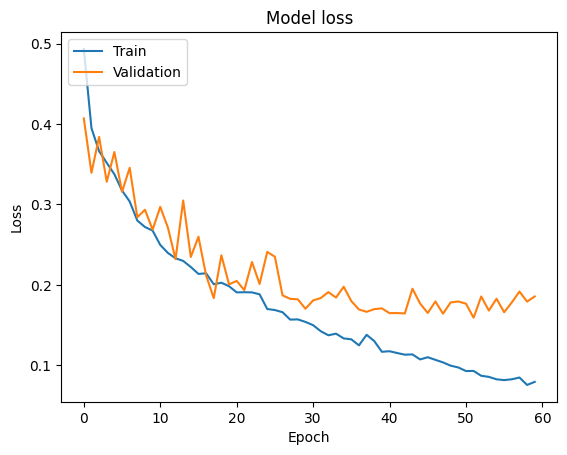

376/376 [==============================] - 32s 80ms/step
Test Loss: 0.18554425239562988
Test Accuracy: 0.9366425275802612
Precision: 0.7858413376022768
F1 Score: 0.8528957528957529
Recall: 0.932460953989025


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/60
188/188 [==============================] - 327s 2s/step - loss: 0.4835 - accuracy: 0.7255 - val_loss: 0.4283 - val_accuracy: 0.7870
Epoch 2/60
188/188 [==============================] - 318s 2s/step - loss: 0.3978 - accuracy: 0.8004 - val_loss: 0.3702 - val_accuracy: 0.8231
Epoch 3/60
188/188 [==============================] - 306s 2s/step - loss: 0.3615 - accuracy: 0.8228 - val_loss: 0.3099 - val_accuracy: 0.8576
Epoch 4/60
188/188 [==============================] - 306s 2s/step - loss: 0.3361 - accuracy: 0.8351 - val_loss: 0.3945 - val_accuracy: 0.8143
Epoch 5/60
188/188 [==============================] - 297s 2s/step - loss: 0.3158 - accuracy: 0.8478 - val_loss: 0.3366 - val_accuracy: 0.8404
Epoch 6/60
188/188 [==============================] - 298s 2s/step - loss: 0.3144 - accuracy: 0.8497 - val_loss: 0.3426 - val_accuracy: 0.8383
Epoch 7/60
188/188 [==============================] - 303s 2s/step - loss: 0.2965 - accuracy: 0.8580 - val_loss: 0.2838 - val_accuracy: 0.8697

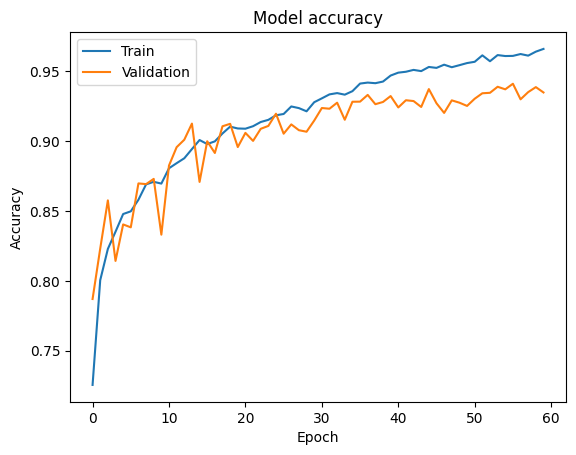

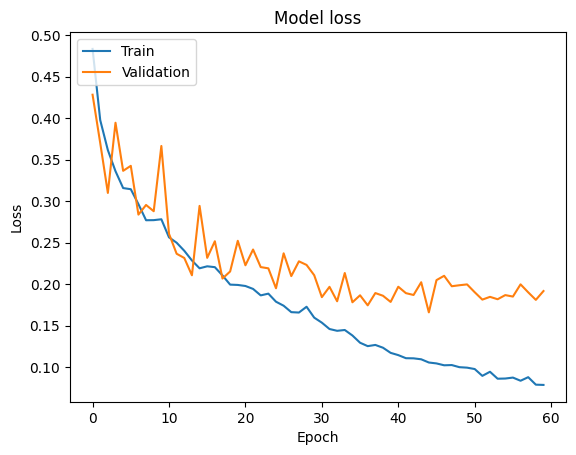

376/376 [==============================] - 30s 72ms/step
Test Loss: 0.19168004393577576
Test Accuracy: 0.9348133206367493
Precision: 0.7893391748813435
F1 Score: 0.8465152701644478
Recall: 0.912621359223301


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/60
178/188 [===========================>..] - ETA: 15s - loss: 0.5027 - accuracy: 0.7286

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Load the pickle file
with open('k_fold_dishwashing.pickle', 'rb') as f:
    data = pickle.load(f)


# Convert one-hot encoded labels to binary labels
binary_Y_train = np.argmax(data.Y_train, axis=1)

# Define the number of folds
k_folds = 5

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=k_folds)


# Initialize lists to store evaluation metrics for each fold
accuracy_scores = []
loss_scores = []
f1_scores = []


# Perform K-fold cross-validation
for train_index, test_index in kf.split(data.X_emg_train, binary_Y_train):
    X_emg_train_fold, X_emg_val_fold = data.X_emg_train[train_index], data.X_emg_train[test_index]
    X_acc_train_fold, X_acc_val_fold = data.X_acc_train[train_index], data.X_acc_train[test_index]
    zc_features_train_fold, zc_features_val_fold = data.zc_features_train[train_index], data.zc_features_train[test_index]
    ssc_features_train_fold, ssc_features_val_fold = data.ssc_features_train[train_index], data.ssc_features_train[test_index]
    features_1d_train_emg_fold, features_1d_val_emg_fold = data.features_1d_train_emg[train_index], data.features_1d_train_emg[test_index]
    features_1d_train_acc_fold, features_1d_val_acc_fold = data.features_1d_train_acc[train_index], data.features_1d_train_acc[test_index]
    Y_train_fold, Y_val_fold = data.Y_train[train_index], data.Y_train[test_index]

    # Build and train the model
    model = BILSTM()
    model.train(X_emg_train_fold, X_acc_train_fold, zc_features_train_fold, ssc_features_train_fold, features_1d_train_emg_fold, features_1d_train_acc_fold, Y_train_fold,
               X_emg_val_fold, X_acc_val_fold, zc_features_val_fold, ssc_features_val_fold, features_1d_val_emg_fold, features_1d_val_acc_fold, Y_val_fold)

    model.evaluate(X_emg_val_fold, X_acc_val_fold, zc_features_val_fold, ssc_features_val_fold, features_1d_val_emg_fold, features_1d_val_acc_fold, Y_val_fold)
    model.save_model()

# Individual Testing
This section allows for training of single models.
NOTE: Ensure Data split is correct. k-fold uses all data and splits on its own; otherwise must select adequate train/val split above in preprocessing section

In [ ]:
# Load the pickle file
with open('0.8_train_val_split.pickle', 'rb') as f:
    data = pickle.load(f)

# Build new model and run
model = BILSTM()
model.train(data.X_emg_train, data.X_acc_train, data.zc_features_train, data.ssc_features_train, data.features_1d_train_emg, data.features_1d_train_acc, data.Y_train,
            data.X_emg_val, data.X_acc_val, data.zc_features_val, data.ssc_features_val, data.features_1d_val_emg, data.features_1d_val_acc, data.Y_val)
model.evaluate(data.X_emg_val, data.X_acc_val, data.zc_features_val, data.ssc_features_val, data.features_1d_val_emg, data.features_1d_val_acc, data.Y_val)
model.save_model()

Epoch 1/60
190/190 [==============================] - 457s 2s/step - loss: 0.4890 - accuracy: 0.7342 - val_loss: 0.4840 - val_accuracy: 0.7498
Epoch 2/60
190/190 [==============================] - 424s 2s/step - loss: 0.3895 - accuracy: 0.8017 - val_loss: 0.3782 - val_accuracy: 0.8169
Epoch 3/60
190/190 [==============================] - 420s 2s/step - loss: 0.3589 - accuracy: 0.8188 - val_loss: 0.3772 - val_accuracy: 0.8189
Epoch 4/60
190/190 [==============================] - 406s 2s/step - loss: 0.3412 - accuracy: 0.8328 - val_loss: 0.3382 - val_accuracy: 0.8354
Epoch 5/60
190/190 [==============================] - 405s 2s/step - loss: 0.3180 - accuracy: 0.8469 - val_loss: 0.3137 - val_accuracy: 0.8523
Epoch 6/60
190/190 [==============================] - 410s 2s/step - loss: 0.3032 - accuracy: 0.8550 - val_loss: 0.3302 - val_accuracy: 0.8522
Epoch 7/60
190/190 [==============================] - 399s 2s/step - loss: 0.2877 - accuracy: 0.8650 - val_loss: 0.2832 - val_accuracy: 0.8710

# Leave-one-out
This section was not utilized in final thesis results, however allowed one to perform a leave-one-out analysis. This analysis allowed one to have a trained model on 7/8 data collections. Then, the model is tested on the final 1 data collection.

Generate Testing Data

In [ ]:
# Prepare paths to data access
print("Prepare Testing Paths:")
paths = []
repository = "/content/drive/MyDrive/Thesis/Data/Segmented_Data/LSTM_GH_Data/Mindrove_Data/Thesis/Testing"

# Check if the directory exists
if os.path.exists(repository):
    # Get all .txt files in the directory
    files = [os.path.join(repository, f) for f in os.listdir(repository) if f.endswith('.txt')]
    paths.extend(files)
else:
    print("Directory does not exist:", repository)

# Preprocessing Signal File
print("Processing Testing Files:")
signals = []
count = 0
for path in paths:
    # if count >= 14:
    #     break
    print(path)
    signal = Signal(path)
    signal.to_numpy()
    signal.generate()
    signal.feature_generation()
    signal.save_data()
    signals.append(signal)
    count += 1

# Concatenate Train val Data
print("Concatenate Signal Data:")
X_emg, X_acc, zc_features, ssc_features, features_1d_emg, features_1d_acc, Y = signals[0].load_data()
for signal in signals[1:]:
    x_emg, x_acc, zc_feature, ssc_feature, feature_1d_emg, feature_1d_acc, y = signal.load_data()
    X_emg = np.append(X_emg, x_emg, axis=0)
    X_acc = np.append(X_acc, x_acc, axis=0)
    zc_features = np.append(zc_features, zc_feature, axis=0)
    ssc_features = np.append(ssc_features, ssc_feature, axis=0)
    features_1d_emg = np.append(features_1d_emg, feature_1d_emg, axis=0)
    features_1d_acc = np.append(features_1d_acc, feature_1d_acc, axis=0)
    Y = np.append(Y, y, axis=0)

# Check for NaN values in concatenated arrays
nan_indices_X_emg = np.argwhere(np.isnan(X_emg))
nan_indices_X_acc = np.argwhere(np.isnan(X_acc))
nan_indices_zc = np.argwhere(np.isnan(zc_features))
nan_indices_ssc = np.argwhere(np.isnan(ssc_features))
nan_indices_features_1d_emg = np.argwhere(np.isnan(features_1d_emg))
nan_indices_features_1d_acc = np.argwhere(np.isnan(features_1d_acc))
nan_indices_Y = np.argwhere(np.isnan(Y))
if len(nan_indices_X_emg) > 0:
    print("NaN values found in X at indices:", nan_indices_X_emg)
if len(nan_indices_X_acc) > 0:
    print("NaN values found in X at indices:", nan_indices_X_acc)
if len(nan_indices_zc) > 0:
    print("NaN values found in zc_features at indices:", nan_indices_zc)
if len(nan_indices_ssc) > 0:
    print("NaN values found in ssc_features at indices:", nan_indices_ssc)
if len(nan_indices_features_1d_emg) > 0:
    print("NaN values found in features_1d at indices:", nan_indices_features_1d_emg)
if len(nan_indices_features_1d_acc) > 0:
    print("NaN values found in features_1d_2 at indices:", nan_indices_features_1d_acc)
if len(nan_indices_Y) > 0:
    print("NaN values found in Y at indices:", nan_indices_Y)

# Prepare Data
#Store Testing Data / X, zc_features, ssc_features, features_1d_emg, features_1d_acc
filenames = ['Test_X_emg.pickle','Test_X_acc.pickle' 'Test_Y.pickle', 'Test_zc_features.pickle', 'Test_ssc_features.pickle', 'Test_features_1d_emg.pickle', 'Test_features_1d_acc.pickle']
data_to_dump = [X_emg, X_acc, Y, zc_features, ssc_features, features_1d_emg, features_1d_acc]
for filename, i in zip(filenames, data_to_dump):
    with open(filename, 'wb') as f:
        pickle.dump(i, f, protocol=pickle.HIGHEST_PROTOCOL)

Prepare Testing Paths:
Processing Testing Files:
/content/drive/MyDrive/Thesis/Data/Segmented_Data/LSTM_GH_Data/Mindrove_Data/Thesis/Testing/8_11_36_05.txt
Generating Data...
Concatenate Signal Data:


Testing Model

In [ ]:
"""
The below code was utilized in leave-one-out testing. It saves the evaluation results and predicted vs. actual labels to a
text file for side-by-side comparison. This is useful when assessing why the model was not predicting as expected.


# Import Pickled Data
filenames = ['Test_X_emg.pickle', 'Test_X_acc.pickle', 'Test_Y.pickle', 'Test_features_1d_acc.pickle', 'Test_features_1d_emg.pickle', 'Test_ssc_features.pickle', 'Test_zc_features.pickle']
variables = ['Test_X_emg', 'Test_Y', 'Test_features_1d_acc', 'Test_features_1d_emg', 'Test_ssc_features', 'Test_zc_features']
for filename, var in zip(filenames, variables):
    with open(filename, 'rb') as f:
        globals()[var] = pickle.load(f) #Make global variables, maybe better way

# Must normalize data
normalized_X, normalized_zc_features, normalized_ssc_features, normalized_features_1d_emg, normalized_features_1d_acc = data.normalize(Test_X, Test_zc_features, Test_ssc_features, Test_features_1d_emg, Test_features_1d_acc)
#Evaluate based on normalized data
evaluation_results = model.evaluate(normalized_X, normalized_zc_features, normalized_ssc_features, normalized_features_1d_emg, normalized_features_1d_acc, Test_Y)
# Predict based on normalized data
predicted_labels = model.predict(normalized_X, normalized_zc_features, normalized_ssc_features, normalized_features_1d_emg, normalized_features_1d_acc)
actual_labels = np.argmax(Test_Y, axis=1)
# Save evaluation results and predicted vs. actual labels to a text file
with open('evaluation_results_with_predictions.txt', 'w') as f:
    print("Evaluation Results:", file=f)
    print("Accuracy:", evaluation_results[0], file=f)
    print("Loss:", evaluation_results[1], file=f)
    print("F1 Score:", evaluation_results[2], file=f)
    print("\nPredicted vs. Actual Y-labels:", file=f)
    for i in range(len(predicted_labels)):
        print(f"Predicted: {predicted_labels[i]}, Actual: {actual_labels[i]}", file=f)

print("Evaluation results with predictions saved to 'evaluation_results_with_predictions.txt'")
"""